In [1]:
from utils import *
from sklearn.manifold import TSNE
from datetime import datetime
import time
import math

In [2]:
#pretty plot
#sns.set_style("darkgrid")
a4_dims = (11.7,11.7)
sns.set_context("paper", font_scale = 1.5, rc={"lines.linewidth":2.5})

# Current TODOs
* Figure out why even though the loss can get to a magnitude of 0.01 the F-Score for slots is still bad
* it was an issue with not cutting off the prediction after the <EOS> token is outputted. But ask Shilad about the batch size issue which affects the scoring with topk(). I think if its more than one batch pytorch picks the last element of the batch.
    
*** Issue is simply because when batching we get [batch , seq len] in one seq the smallest number should be <eos> but when batch size is >1 we have multiple batches together so value for <eos> occurs later than normal messing up evaluation. To get correct evaluation use batch_size =1 ***


In [3]:
MAX_LENGTH = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reading the Data In

In [4]:
with open('data/preprocessed/fold_train.json', 'r') as f:
    atis_json = json.load(f)

# Data Preprocessing

In [5]:
def flatten(list_of_lists):
    """Flattens from two-dimensional list to one-dimensional list"""
    return [item for sublist in list_of_lists for item in sublist]

In [6]:
def adjust_sequences(data, length=MAX_LENGTH):
    """
    Fixes the input and output sequences length, adding padding or truncating if necessary
    :param data json file containing entries from atis dataset.
    :param length the fixed length of the sentence.
    """
    for sample in data['data']:
        # adjust the sequence of input words
        if len(sample['words']) < length:
            # add <EOS> and <PAD> if sentence is shorter than maximum length
            sample['words'].append('<EOS>')
            while len(sample['words']) < length:
                sample['words'].append('<PAD>')
        else:
            # otherwise truncate and add <EOS> at last position
            sample['words'] = sample['words'][:length]
            sample['words'][-1] = '<EOS>'

        # adjust in the same way the sequence of output slots
        if len(sample['slots']) < length:
            sample['slots'].append('<EOS>')
            while len(sample['slots']) < length:
                sample['slots'].append('<PAD>')
        else:
            sample['slots'] = sample['slots'][:length]
            sample['slots'][-1] = '<EOS>'

    return data

In [7]:
def get_vocabularies(train_data):
    """
    Collect the input vocabulary, the slot vocabulary and the intent vocabulary
    :param train_data the training data containing words,slots and intent.
    """
    # from a list of training examples, get three lists (columns)
    data = train_data['data']
    seq_in = [sample['words'] for sample in data]
    vocab = flatten(seq_in)
    # removing duplicated but keeping the order
    v = ['<PAD>', '<SOS>', '<EOS>'] + vocab
    vocab = sorted(set(v), key=lambda x: v.index(x)) # https://docs.python.org/3.3/howto/sorting.html
    s = ['<PAD>', '<SOS>', '<EOS>'] + train_data['meta']['slot_types']
    slot_tag = sorted(set(s), key=lambda x: s.index(x))
    i = train_data['meta']['intent_types']
    intent_tag = sorted(set(i), key=lambda x: i.index(x))

    return vocab, slot_tag, intent_tag

In [8]:
adjusted_atis = adjust_sequences(atis_json)#padded

In [9]:
atis_vocab,atis_slots,atis_intents = get_vocabularies(adjusted_atis)

In [10]:
len(atis_vocab),len(atis_slots),len(atis_intents)

(870, 123, 21)

In [ ]:
atis_intents

# Next we map the data and set it up for Pytorch
Remember each vocabulary for each sentence, slot and intent will have different embeddings. They are different sized vectors. The Network will try to figure out a mapping from these different vector spaces.

In [11]:
def create_mappings(vocab,forward_map,intent=False):
    """
    This function takes the words in the vocabulary and creates a unique mapping to a number.
    :param vocab contains all the words in the corpus.
    :param forward_map a dictionary that will be populated with mappings.
    returns populated forward_map
    """
    for sample in vocab:
        if not intent and sample not in forward_map.keys():
            forward_map[sample]= len(forward_map)
        elif intent:
            forward_map[sample]= len(forward_map)#+1# this so we can use 1 loss function
            
    return forward_map

In [12]:
word2index = {'<PAD>': 0, '<UNK>':1,'<SOS>':2,'<EOS>':3}
create_mappings(atis_vocab,word2index)
index2word = {v:k for k,v in word2index.items()}

In [13]:
tag2index = {'<PAD>' : 0,'<UNK>':1,'<SOS>':2,'<EOS>':3}
create_mappings(atis_slots,tag2index)
index2tag = {v:k for k,v in tag2index.items()}

In [14]:
intent2index={}
create_mappings(atis_intents,intent2index,intent=True)
index2intent = {v:k for k,v in intent2index.items()}

In [37]:
len(word2index)
len(intent2index)
#word2index
#index2intent
#tag2index

21

### Next we create a Tensor where each row is a mapped/embedded sequence

In [15]:
def prepare_sequence(seq_data, mapping,map_type):
    """
    :param seq a sequnce which will be embedded as a vector
    :param mapping, a dictionary which contains how each element in the seq will be mapped to a number.
    :param map_type 'words','slots' or 'intent'
    returns a Pytorch Tensor.
    """
    if map_type=='intent':
        intent = seq_data[map_type]
        embeddings = mapping[intent] if intent in mapping.keys() else -1 #mapping["<UNK>"]
        return torch.tensor(embeddings)   
    else:
        embed_fnc = lambda word: mapping[word] if word in mapping.keys() else mapping['<UNK>']
        embeddings = list(map(embed_fnc, seq_data[map_type])) 
        return torch.LongTensor(embeddings)

In [16]:
def create_training_set(padded_atis):
    """
    :param padded_atis, this is padded sequence data.
           Of the form seq,slots,intent. This function coverts 
           these into tensors.
    return train_data; [(seq_tensor,slot_tensor,intent_tensor)]
    """
    train_data = []
    atis_data = padded_atis['data']
    for i in range(len(atis_data)):
        seq_tensor = prepare_sequence(atis_data[i],word2index,'words')
        slot_tensor = prepare_sequence(atis_data[i],tag2index,'slots')
        intent_tensor = prepare_sequence(atis_data[i],intent2index,'intent')
        train_data.append((seq_tensor,slot_tensor,intent_tensor))
    return train_data

In [17]:
train_data = create_training_set(adjusted_atis)

## Batching the data

In [18]:
def concatenate_batch(batch):
#     print(len(batch), len(batch[0]))
    #     print([ex[0] for ex in batch])
    seqs = torch.stack([ex[0] for ex in batch])
    slots = torch.stack([ex[1] for ex in batch])
    intents = torch.stack([ex[2] for ex in batch])
   
    return seqs,slots,intents

In [19]:
def get_batches(batch_size, train_data):
    """
    Returns iteratively a batch of specified size on the data. 
    The last batch can be smaller if the total size is not multiple of the batch
    """
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while sindex < len(train_data):
        batch = train_data[sindex:eindex] #list of batch_size num of tuples.
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        #print('returning', len(batch), 'samples')
        yield concatenate_batch(batch)

# Building Joint-RNN Model
---Ignore---

Will use encoder-decoer model because of:
Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." Advances in neural information processing systems. 2014.

i) one for the input sequence and another for the output sequence, because doing
so increases the number model parameters at negligible computational cost and makes it natural to
train the LSTMon multiple language pairs simultaneously 

ii) deep LSTMs significantly outperformed shallow LSTMs, so we chose an LSTM with four layers. 

iii) valuable to reverse the order of the words of the input sentence. 

---Ignore---

In [20]:
class Encoder(nn.Module):
    """
    An encoder/decoder that
    takes a batch of sequences embeds the sequence and
    then runs it through a fully connected layer to predict slots and intent.
    """
    def __init__(self,input_dim,hidden_dim,emb_dim,slot_dim,intent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
       
        self.slot_dim = slot_dim
        self.intent_dim = intent_dim
       
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim,batch_first=True)
        
        self.slot_fc = nn.Linear(hidden_dim,slot_dim)
        self.intent_fc = nn.Linear(hidden_dim,intent_dim)
        
    def forward(self,src):
        #src [seq len,batch size] -> [seq len, batch size, emb_dim]
        embedded_seq = self.embedding(src)
        outputs, hidden = self.rnn(embedded_seq)
        outputs = outputs.contiguous().view(-1,self.emb_dim)
   
        slot_space = self.slot_fc(outputs)
        slot_scores = slot_space

        intent_space = self.intent_fc(hidden)
        intent_scores = intent_space

        return slot_scores, intent_scores, hidden

In [ ]:
#train_data[0]

In [ ]:
print("Testing models...")
n_layers = 1
input_size = len(word2index)
slot_size = len(tag2index)
intent_size = len(intent2index)
embed_size = 5
hidden_size = 5
output_size = MAX_LENGTH
encoder = Encoder(input_size, embed_size,hidden_size,slot_size,intent_size).to(device)

In [ ]:
for batch in get_batches(256,train_data[:]):
    inputs = batch[0]
    inputs = inputs.to(device)
    #slots = encoder(inputs)
    slots, intents,_ = encoder(inputs)
    #print(torch.argmax(slots,dim=0))

# Training the model & Running Experiments

In [21]:
def train_model(model,optimizer,train_data,constant_params):
    loss_by_epoch = {}
    criterion = constant_params['criterion']
    model.train()
    for epoch in range(constant_params['num_epoch']):
        slot_losses = []
        intent_losses = []
        inp = get_batches(constant_params['batch_size'],train_data)
        for data in inp:
            inputs, labels, intents = data[0],data[1],data[2]
            inputs = inputs.type(torch.LongTensor).to(device)
            labels = labels.type(torch.LongTensor).view(-1).to(device) #squashing
            intents = intents.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out_slots, out_intents,_ = model(inputs)
            out_slots = out_slots.view(-1,constant_params['SLOT_DIM'])
            out_intents = out_intents.view(-1,constant_params['INTENT_DIM'])
            
            slot_loss = criterion(out_slots, labels)
            intent_loss = criterion(out_intents, intents) 
            
            slot_losses.append(slot_loss.item())
            intent_losses.append(intent_loss.item())
            
            slot_loss.backward(retain_graph=True)
            intent_loss.backward()
            optimizer.step()
        slot_col_name = "epoch:"+str(epoch+1)+"_slot_losses"
        intent_col_name = "epoch:"+str(epoch+1)+"_intent_losses"
        loss_by_epoch[slot_col_name] = slot_losses
        loss_by_epoch[intent_col_name] = intent_losses
        
    return loss_by_epoch #slot_losses, intent_losses,

def make_models(constant_params,vary_params):
    #make a model with a different embedding size
    model_list = []
    for i in range(len(vary_params['embed_size'])):
        model_list.append( Encoder(constant_params['INPUT_DIM'],
                                   vary_params['embed_size'][i],
                                   vary_params['embed_size'][i],
                                      constant_params['SLOT_DIM'],
                                      constant_params['INTENT_DIM']).to(device) )
    return model_list

def run_experiment(constant_params,vary_params,num_runs,exp_data,model_type='ann'):
    experiment_results = {}
    list_of_dfs = []
    for run in range(num_runs): # fill dict with keys
        for i in range(len(vary_params['embed_size'])):
            col_name = 'run_'+str(run+1)+'_embed_size_'+str(vary_params['embed_size'][i])
            experiment_results[col_name] = []
           
    for run in range(num_runs):# run actual experiments
        run_model_list = make_models(constant_params,vary_params)
        for i in range(len(run_model_list)):
            optimizer = optim.Adam(run_model_list[i].parameters(), lr=0.01)
            col_name = 'run_'+str(run+1)+'_embed_size_'+str(vary_params['embed_size'][i])
           
            loss_by_epoch = train_model(run_model_list[i],
                                       optimizer,
                                       exp_data,
                                       constant_params)
            
            result_dataframe = pd.DataFrame(loss_by_epoch,index=None)
            result_dataframe.to_csv("experiment_results/"+
                                    str(model_type)+
                                    str(run)+"_"+
                                    str(vary_params['embed_size'][i])+"_"
                                    "train_experiment.csv")
            list_of_dfs.append(result_dataframe)
            #experiment_results[col_name].append(loss_by_epoch)
            #experiment_results[col_name].append(run_intent_losses)
                
    # after experiments are over save as a .csv
#     result_dataframe = pd.DataFrame(experiment_results,index=None)
#     result_dataframe.to_csv("experiment_results/"+str(model_type)+"train_experiments.csv")
    return list_of_dfs #incase we want it

In [ ]:
constant_exp_params = {'batch_size':128,
                       'num_epoch':200,
                      'INPUT_DIM':len(word2index),
                      'SLOT_DIM':len(tag2index),
                      'INTENT_DIM':len(index2intent),
                      'criterion': nn.CrossEntropyLoss(ignore_index=0,reduction='elementwise_mean')}

variable_exp_params = {'embed_size':[2,4,8,16,32,64,128,256]}
                        

In [ ]:
start = time.time()
run_experiment(constant_exp_params,variable_exp_params,5,train_data,model_type='rnn')
end = time.time()
elapsed = (end-start)/60.
print('Time elapsed: %.4f mins ' % (elapsed))

# ===============================================

In [22]:
n_layers = 1
input_size = len(word2index)
slot_size = len(tag2index)
intent_size = len(intent2index)
embed_size = 16
hidden_size = 16
#output_size = MAX_LENGTH
encoder = Encoder(input_size, embed_size,hidden_size,slot_size,intent_size).to(device)
#-----------------------
criterion = nn.CrossEntropyLoss(ignore_index=0,reduction='elementwise_mean')#ignore <pad> remember this ignoring 0 in intent as well, need 2 loss
optimizer = optim.Adam(encoder.parameters(), lr=0.01)
#batch_size = 100

In [ ]:
encoder

In [23]:
num_epochs = 200
start = time.time()
for epoch in range(num_epochs):
    inp = get_batches(128,train_data)
    encoder.train()
    for data in inp:
        # get the inputs
        inputs, labels, intents = data[0],data[1],data[2]
        inputs = inputs.type(torch.LongTensor).to(device)
        labels = labels.type(torch.LongTensor).view(-1).to(device) #squashing
        intents = intents.to(device)#.type(torch.FloatTensor)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        #out_slots = encoder(inputs)
        out_slots, out_intents,_ = encoder(inputs)
        slot_loss = criterion(out_slots, labels)
        #print(out_intents.size(),intents.size())
        out_intents = out_intents.view(-1,intent_size)
        intent_loss = criterion(out_intents, intents) 

       # slot_loss.backward()        
        slot_loss.backward(retain_graph=True)
        intent_loss.backward()
        optimizer.step()

    if epoch%5==0:
        print('Slot Loss after epoch '+str(epoch)+':',slot_loss.item())
        print('Intent Loss after epoch '+str(epoch)+':',intent_loss.item())
        print('-----------------------------------------------')
end = time.time()
elapsed = (end-start)/60.
print('Time elapsed: %.4f mins ' % (elapsed))

Slot Loss after epoch 0: 1.5684068202972412
Intent Loss after epoch 0: 0.9648672342300415
-----------------------------------------------
Slot Loss after epoch 5: 0.28207698464393616
Intent Loss after epoch 5: 1.2195119857788086
-----------------------------------------------
Slot Loss after epoch 10: 0.1409992128610611
Intent Loss after epoch 10: 1.0365335941314697
-----------------------------------------------
Slot Loss after epoch 15: 0.12779967486858368
Intent Loss after epoch 15: 0.9829643964767456
-----------------------------------------------
Slot Loss after epoch 20: 0.08411911129951477
Intent Loss after epoch 20: 0.84554523229599
-----------------------------------------------
Slot Loss after epoch 25: 0.0497591570019722
Intent Loss after epoch 25: 1.107553482055664
-----------------------------------------------
Slot Loss after epoch 30: 0.08051232248544693
Intent Loss after epoch 30: 0.9986213445663452
-----------------------------------------------
Slot Loss after epoch 3

# Evaluation
Our Vanilla RNN does poorly on intent detection, only predicting 11 as the intent. This happens because with a vanilla RNN, the final hidden state only takes into account the final word. Also 11 (atis_flight) is the most common intent in the data set. Possibly an LSTM would help as the context vector holds features about other parts of the query other than the last word.

In [24]:
with open('data/preprocessed/fold_test.json', 'r') as f:
    atis_test_json = json.load(f)

In [25]:
adjusted_atis_test = adjust_sequences(atis_test_json)#padded

In [26]:
test_data = create_training_set(adjusted_atis_test) 

In [38]:
#Exclude pad 
def calc_bat_fscores(y_pred,y_true,predict_type='slot'):
    """
    Calc average f score for a batch.
    compares each predicted output in a batch to actual output.
    Then averages that.
    """
    batch_avg_f = []
    keep_slots = [i for i in tag2index.values() if (i > 3 and i!=123)]#filter out unk,pad,sos,eos
    if predict_type=='slot':
#         for pred_i in range(len(y_pred)):# range batch size
            #print(y_pred[pred_i].size())
        f_score = f1_score(y_true[:len(y_pred)], y_pred,labels=keep_slots, average ='micro')  
        batch_avg_f.append(f_score)
    else:
        return f1_score(y_true,y_pred,average ='micro')
    return np.mean(batch_avg_f)

In [34]:
import warnings
warnings.filterwarnings('ignore')# get a lot of warnings because some labels are not predicted...

In [39]:
inp = get_batches(1,test_data)
encoder.eval()
f_slot_scores = []
f_intent_scores = []
for data in inp:
    # get the inputs
    inputs, labels , true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor).to(device)
    labels = labels.type(torch.LongTensor).view(-1).to(device) #squashing
    true_intents = true_intents.to(device)
    
    enc_output ,intents, slot_embedding = encoder(inputs)
    #enc_output = encoder(inputs)
    y_pred_slots = torch.argmax(enc_output,dim=1)
    eos_idx = y_pred_slots.topk(1,largest=False)[1].item()
    eos_cut_slots = y_pred_slots[:eos_idx]
    f_slot_scores.append(calc_bat_fscores(eos_cut_slots,labels.view(-1)))
    y_pred_intents = torch.argmax(intents,dim=2)
    #print(y_pred_intents)
    f_intent_scores.append(calc_bat_fscores(y_pred_intents[0],true_intents,predict_type='intent'))
#    print(eos_idx,y_pred_slots)
print('Mean Slot F Metric :',np.mean(f_slot_scores))
print('-----------------------------------------------')  
print('Mean Intent F Metric :',np.mean(f_intent_scores))

Mean Slot F Metric : 0.9194647632306672
-----------------------------------------------
Mean Intent F Metric : 0.714


In [ ]:
#torch.topk()

## Confusion Matrix

In [27]:
def categoryFromOutput(output):
    category_i = output.item()
    return index2intent[category_i], category_i

In [28]:
for data in get_batches(1,test_data[0:1]):
    input,_,intent = data[0],data[1],data[2]
    input = input.to(device)
    #print(input.size())
    output,intent_pred,_  = encoder(input)
    print(intent_pred.size())
    predictions = torch.argmax(intent_pred,dim=2)[0]
    print(output.size())# not really important need to take time to document properly
    print(predictions)
    print(categoryFromOutput(predictions))


torch.Size([1, 1, 21])
torch.Size([50, 124])
tensor([11])
('atis_flight', 11)


In [29]:
all_categories = []
intent_labels = ['abbreviation','aircraft','aircraft#flight#flight_no',
                 'airfare','airline','airline#flight_no','airport','capacity',
                'cheapest','city','distance','flight','flight#airfare','flight_no','flight_time',
                 'ground_fare','ground_fare_service','ground_service#ground_fare','meal',
                'quantity','restriction']
for category in intent2index.values():
    all_categories.append(category)
      
len(all_categories),len(intent_labels)

(21, 21)

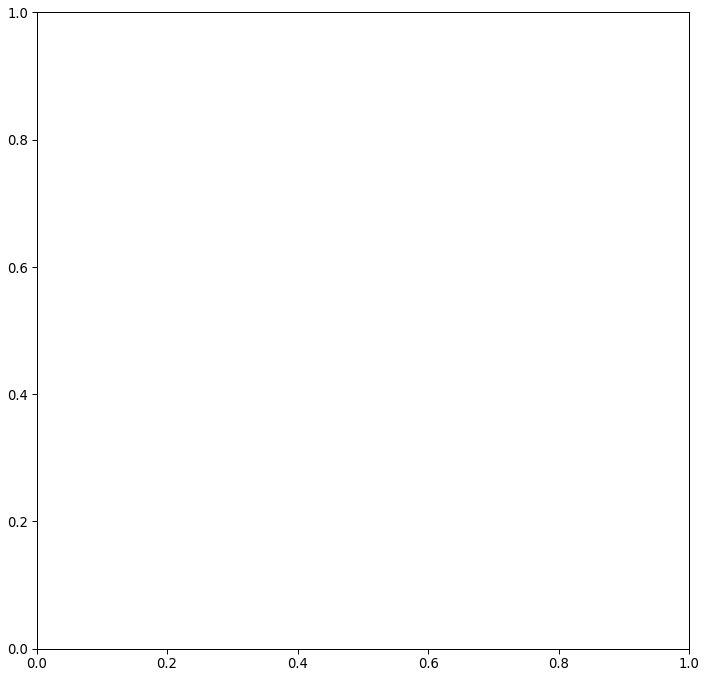

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
new_dims = (15,15)
fig, ax = plt.subplots(figsize=a4_dims)

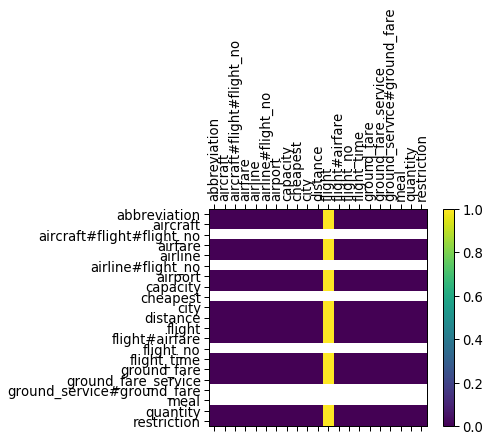

In [32]:
# Keep track of correct guesses in a confusion matrix
n_categories = len(all_categories)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 5000

# Go through a bunch of examples and record which are correctly guessed
for data in get_batches(1,test_data):
    inputs, labels , true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor).to(device)
    labels = labels.to(device)
    true_intents = true_intents.to(device)
    output,intent_pred,_  = encoder(inputs)
    predictions = torch.argmax(intent_pred,dim=2)[0]
    #print(predictions, true_intents)
    guess, guess_i = categoryFromOutput(predictions)
    if true_intents.item()!= -1:#intent is in dataset
        category_i = all_categories.index(true_intents)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + intent_labels, rotation=90)
ax.set_yticklabels([''] + intent_labels) #true

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
#plt.test_datashow()
fig = ax.get_figure()
fig.savefig("graphs/rnn16_cm_with_intent",bbox_inches="tight",dpi=300)